In [1]:
#  Dependencies
import pandas as pd
import numpy as np
import requests
from elasticsearch import Elasticsearch,helpers
import certifi
from datetime import datetime,timedelta
import radar
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Initializing Elasticsearch

In [2]:

host_name ='https://9e2a4b7052bdf8fd2685a0f5a35ae274.ap-southeast-1.aws.found.io'

In [3]:
# initialise elastic search with authorisation
es = Elasticsearch(
        [host_name],
        port=9243,
        http_auth=("gsoc","vyom@gsoc"),
        use_ssl=True,
        verify_certs=True,
        ca_certs=certifi.where(),
    )

In [4]:
es.ping()

True

In [5]:
r= requests.get(host_name, auth=('gsoc','vyom@gsoc'))
if r.status_code ==200:
    print('Everthing is working fine. Status code is {}'.format(r.status_code))
else:
    print('Something went wrong , get status is {}'.format(r.status_code))

Everthing is working fine. Status code is 200


In [6]:
es.info()

{'cluster_name': '9e2a4b7052bdf8fd2685a0f5a35ae274',
 'name': 'instance-0000000000',
 'status': 200,
 'tagline': 'You Know, for Search',
 'version': {'build_hash': 'c730b59357f8ebc555286794dcd90b3411f517c9',
  'build_snapshot': False,
  'build_timestamp': '2016-11-18T15:21:16Z',
  'lucene_version': '4.10.4',
  'number': '1.7.6'}}

In [7]:
es.get_source(index='ft_initial', id=1, doc_type='transfer')

{'bytes': 4566010065,
 'dst_site': 'data center a',
 'event_type': 'transfer-queued',
 'src_site': 'data center b',
 'timestamp': '2017-01-14T01:05:28',
 'uuid': '3b416acc-af8b-44f9-af2a-e98f33cb52fa'}

In [8]:
es.get_source(index='ft_final', id=1, doc_type='transfer')

{'bytes': 4566010065,
 'dst_site': 'data center a',
 'event_type': 'transfer-success',
 'src_site': 'data center b',
 'timestamp': '2017-01-14T03:45:52',
 'uuid': '3b416acc-af8b-44f9-af2a-e98f33cb52fa'}

# Exploring Cluster Data

In [10]:
# query={"query": {"match_all": {}}}
query={"query": {"match": {'src_site' : 'data center b'}}}

In [11]:
es.search(index='ft_initial', doc_type='transfer', body=query, size=5)

{'_shards': {'failed': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': '10016',
    '_index': 'ft_initial',
    '_score': 1.5428205,
    '_source': {'bytes': 5705969060,
     'dst_site': 'data center d',
     'event_type': 'transfer-queued',
     'src_site': 'data center b',
     'timestamp': '2017-02-03T19:28:52',
     'uuid': '3d07d3ea-a655-4d17-8730-4646a89d513b'},
    '_type': 'transfer'},
   {'_id': '10018',
    '_index': 'ft_initial',
    '_score': 1.5428205,
    '_source': {'bytes': 7245765330,
     'dst_site': 'data center d',
     'event_type': 'transfer-queued',
     'src_site': 'data center b',
     'timestamp': '2017-01-06T15:27:45',
     'uuid': 'e88fc723-d435-420c-988d-52a2e6c3dbf4'},
    '_type': 'transfer'},
   {'_id': '10020',
    '_index': 'ft_initial',
    '_score': 1.5428205,
    '_source': {'bytes': 9985157536,
     'dst_site': 'data center a',
     'event_type': 'transfer-queued',
     'src_site': 'data center b',
     'timestamp': '2017-02-26T11:29:54

# Retrieving a portion of data using iterative scanning


In [32]:
query={"query": {"match_all": {}}}
sns.set_context('poster')

In [36]:
# implementing scan and scroll
def center_plots(scan_size, scan_step):
    
    # Initialize the scroll
    page = es.search(
    index = 'ft_final',
    doc_type = 'transfer',
    scroll = '20m',
    search_type = 'scan',
    size = scan_step,
    body = query
    )
    sid = page['_scroll_id']
    scroll_size = page['hits']['total']
    results=[]
    steps = int(scan_size / scan_step)

    # Start scrolling

    for i in range(steps):
        print("Scrolling ft_final ...")
        page = es.scroll(scroll_id = sid, scroll = '20m')
        # Update the scroll ID
        sid = page['_scroll_id']
        # Get the number of results that we returned in the last scroll
        scroll_size = len(page['hits']['hits'])
        print("scroll size: " + str(scroll_size))
        for hit in page['hits']['hits']:
            results.append(hit['_source'])
        
    results = pd.DataFrame(results)
    num_rows= results.shape[0]
#     plt.figure(figsize=(12,8))
    print('plotting basic data info.....\n')
    ax = sns.countplot(x='src_site',data= results)
    plt.show()
    gx= sns.countplot(x='dst_site', data = results)
    plt.show()
    vx = sns.countplot(x='event_type', data = results)
    plt.show()
    
    return results  

Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
Scrolling ft_final ...
scroll size: 100
plotting basic data info.....



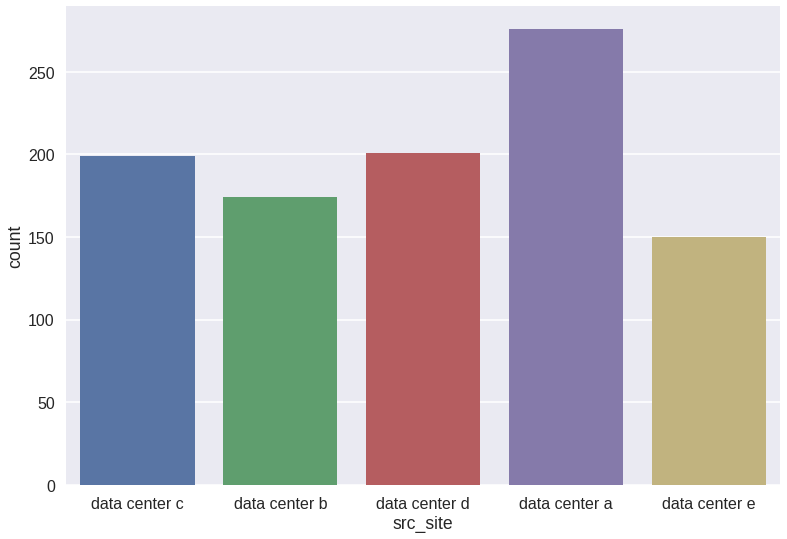

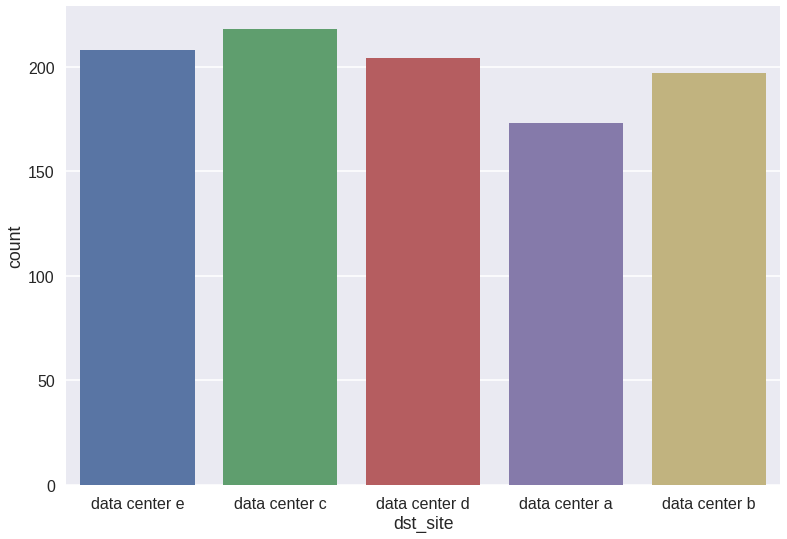

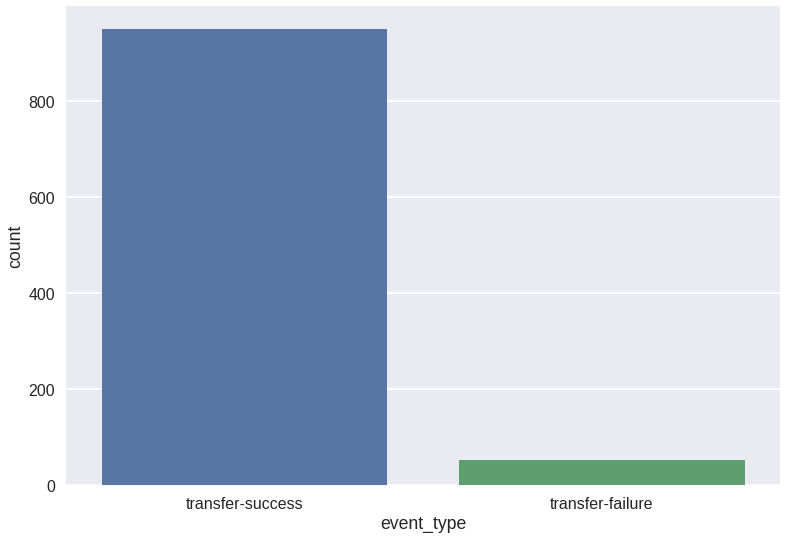

In [37]:
data_slice = center_plots(scan_size= 1000, scan_step=100)

In [38]:
data_slice.shape

(1000, 6)

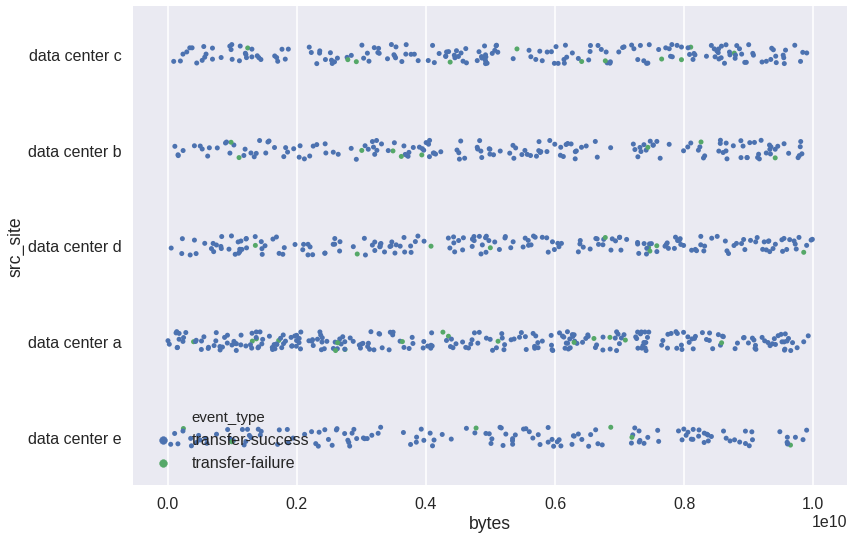

In [47]:
sns.stripplot(y="src_site", x="bytes",hue='event_type', data=data_slice, jitter=True)
plt.show()

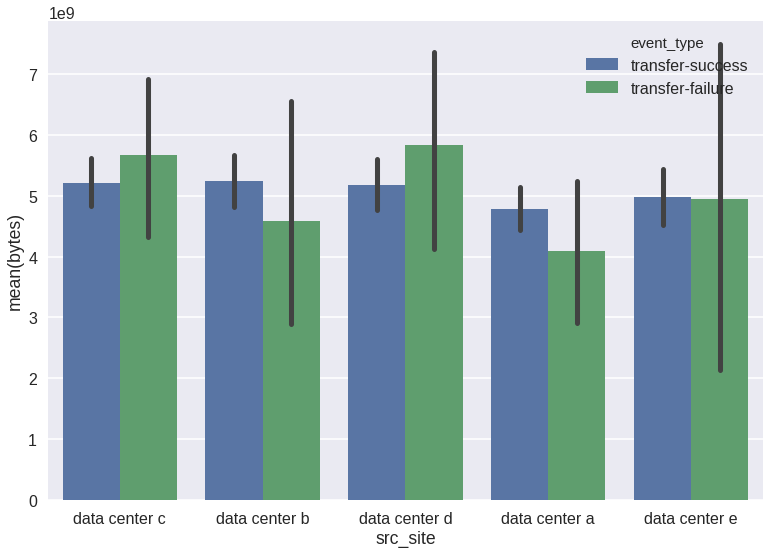

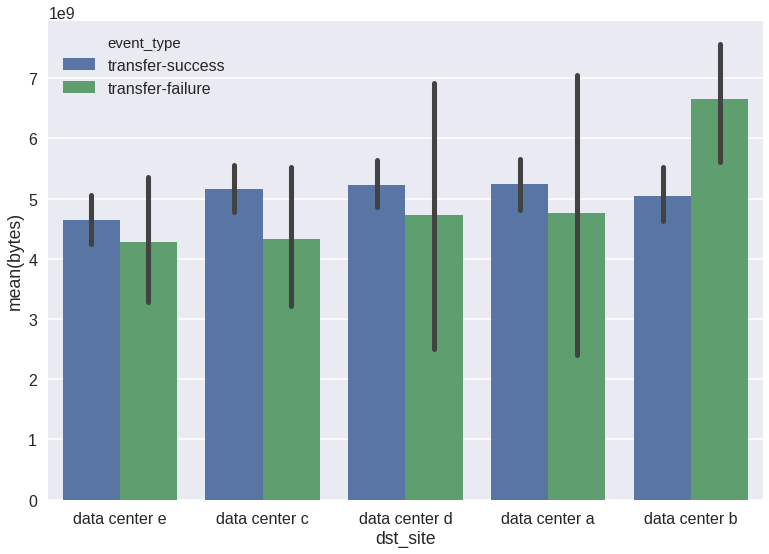

In [46]:
sns.barplot(x="src_site", y="bytes",hue='event_type', data=data_slice)
plt.show()

sns.barplot(x="dst_site", y="bytes",hue='event_type', data=data_slice)
plt.show()

In [14]:
# r=helpers.scan(es, query=query, scroll=u'5m', raise_on_error=True, preserve_order=False, size=1000, request_timeout=None, clear_scroll=True)

# Getting all data for the machine learning model

In [ ]:
query={"query": {"match_all": {}}}

In [20]:
# Initialize the scroll
page = es.search(
index = 'ft_final',
doc_type = 'transfer',
scroll = '10m',
search_type = 'scan',
size = 100000,
body = query
)

sid = page['_scroll_id']
scroll_size = page['hits']['total']

i=0
# Start scrolling

list1=[]
while (scroll_size > 0):
# while i<1:
    print("Scrolling ft_final index....")
    page = es.scroll(scroll_id = sid, scroll = '10m')
    # Update the scroll ID
    sid = page['_scroll_id']
    # Get the number of results that we returned in the last scroll
    scroll_size = len(page['hits']['hits'])
    print("scroll size: " + str(scroll_size))
    print('page type:',type(page))
    print(type(page['hits']['hits']))
    print(len(page['hits']['hits']))
    for hit in page['hits']['hits']:
#         print(hit['_source'])
#       print(type(hit['_source']))
        list1.append(hit['_source'])
#         print("dict appended to list")
    
#     i=i+1

Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 0
page type: <class 'dict'>
<class 'list'>
0


In [21]:
len(list1)

1000000

In [22]:
df1= pd.DataFrame(list1)

In [23]:
df1.head()

,bytes,dst_site,event_type,src_site,timestamp,uuid
0,8940116437,data center e,transfer-success,data center c,2017-02-26T08:59:53,ebbf565d-7e70-4677-9f07-b08d72051ddb
1,1288661369,data center c,transfer-success,data center b,2017-02-03T09:14:05,3ba82468-6516-4d6f-883c-1ac1108c3d89
2,4230378729,data center d,transfer-success,data center b,2017-01-21T01:26:39,22b1ff08-a2ec-427e-b53b-fea91787e7b5
3,8116545364,data center a,transfer-success,data center d,2017-02-08T05:53:03,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50
4,5182557683,data center e,transfer-success,data center a,2017-01-23T12:50:15,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3


In [24]:
# df1.to_csv('df1.csv')

In [25]:
df1.shape

(1000000, 6)

In [26]:
# Initialize the scroll
page = es.search(
index = 'ft_initial',
doc_type = 'transfer',
scroll = '10m',
search_type = 'scan',
size = 100000,
body = query
)

sid = page['_scroll_id']
scroll_size = page['hits']['total']

list1=[]
# i=0
# Start scrolling
while (scroll_size > 0):
# while i<1:
    print("Scrolling ft_initial index....")
    page = es.scroll(scroll_id = sid, scroll = '10m')
    # Update the scroll ID
    sid = page['_scroll_id']
    # Get the number of results that we returned in the last scroll
    scroll_size = len(page['hits']['hits'])
    print("scroll size: " + str(scroll_size))
    print('page type:',type(page))
    print(type(page['hits']['hits']))
    print(len(page['hits']['hits']))
    for hit in page['hits']['hits']:
#         print(hit['_source'])
#       print(type(hit['_source']))
        list1.append(hit['_source'])
#         print("dict appended to list")
    
#     i=i+1

Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 100000
page type: <class 'dict'>
<class 'list'>
100000
Scrolling...
scroll size: 0
page type: <class 'dict'>
<class 'list'>
0


In [27]:
df2 = pd.DataFrame(list1)

In [28]:
df2.head()

,bytes,dst_site,event_type,src_site,timestamp,uuid
0,5501044291,data center b,transfer-queued,data center e,2017-01-21T20:16:55,378d4d93-2fd3-4d67-9f1d-589d52e42069
1,5841332618,data center b,transfer-queued,data center e,2017-01-03T10:14:05,a5efd989-ee82-43db-b365-8a2bba7fb495
2,715530667,data center b,transfer-queued,data center c,2017-02-18T21:08:16,b6f36749-41f8-4ad3-ba11-4f3456a097f5
3,8775843199,data center c,transfer-queued,data center a,2017-02-21T16:11:58,0e8fc495-e0a4-4bda-b749-0fdfee3d3abf
4,7318082996,data center d,transfer-queued,data center a,2017-01-22T07:29:07,9e0bc963-5b1f-4558-a61f-e7db031a2113


In [29]:
# df2.to_csv('df2.csv')

In [30]:
df2.shape

(1000000, 6)

In [31]:
# list1=[]

# Merging the two dataframes

In [32]:
df_n = pd.merge(df1, df2, on=['uuid','bytes','dst_site','src_site'], how='inner')

In [33]:
df_n.shape

(1000000, 8)

In [18]:
df_n.head()

,bytes,dst_site,event_type_x,src_site,timestamp_x,uuid,event_type_y,timestamp_y
0,8940116437,data center e,transfer-success,data center c,2017-02-26T08:59:53,ebbf565d-7e70-4677-9f07-b08d72051ddb,transfer-queued,2017-02-26T06:33:16
1,1288661369,data center c,transfer-success,data center b,2017-02-03T09:14:05,3ba82468-6516-4d6f-883c-1ac1108c3d89,transfer-queued,2017-02-03T07:24:37
2,4230378729,data center d,transfer-success,data center b,2017-01-21T01:26:39,22b1ff08-a2ec-427e-b53b-fea91787e7b5,transfer-queued,2017-01-20T23:02:41
3,8116545364,data center a,transfer-success,data center d,2017-02-08T05:53:03,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,transfer-queued,2017-02-08T03:33:31
4,5182557683,data center e,transfer-success,data center a,2017-01-23T12:50:15,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,transfer-queued,2017-01-23T10:31:50


In [20]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224824 entries, 0 to 224823
Data columns (total 8 columns):
bytes           224824 non-null int64
dst_site        224824 non-null object
event_type_x    224824 non-null object
src_site        224824 non-null object
timestamp_x     224824 non-null object
uuid            224824 non-null object
event_type_y    224824 non-null object
timestamp_y     224824 non-null object
dtypes: int64(1), object(7)
memory usage: 15.4+ MB


In [34]:
df_n['timestamp_x']= pd.to_datetime(df_n['timestamp_x'], infer_datetime_format=True)
df_n['timestamp_y']= pd.to_datetime(df_n['timestamp_y'], infer_datetime_format=True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
bytes           1000000 non-null int64
dst_site        1000000 non-null object
event_type_x    1000000 non-null object
src_site        1000000 non-null object
timestamp_x     1000000 non-null datetime64[ns]
uuid            1000000 non-null object
event_type_y    1000000 non-null object
timestamp_y     1000000 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 68.7+ MB


In [35]:
df_n['time_taken']= df_n['timestamp_x'] - df_n['timestamp_y']

In [36]:
df_n.head()

,bytes,dst_site,event_type_x,src_site,timestamp_x,uuid,event_type_y,timestamp_y,time_taken
0,8940116437,data center e,transfer-success,data center c,2017-02-26 08:59:53,ebbf565d-7e70-4677-9f07-b08d72051ddb,transfer-queued,2017-02-26 06:33:16,02:26:37
1,1288661369,data center c,transfer-success,data center b,2017-02-03 09:14:05,3ba82468-6516-4d6f-883c-1ac1108c3d89,transfer-queued,2017-02-03 07:24:37,01:49:28
2,4230378729,data center d,transfer-success,data center b,2017-01-21 01:26:39,22b1ff08-a2ec-427e-b53b-fea91787e7b5,transfer-queued,2017-01-20 23:02:41,02:23:58
3,8116545364,data center a,transfer-success,data center d,2017-02-08 05:53:03,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,transfer-queued,2017-02-08 03:33:31,02:19:32
4,5182557683,data center e,transfer-success,data center a,2017-01-23 12:50:15,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,transfer-queued,2017-01-23 10:31:50,02:18:25


In [37]:
# df_n['time_taken'] = pd.Timedelta(df_n['time_taken'])
df_n['time_taken'] = df_n['time_taken'].astype('timedelta64[s]')
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
bytes           1000000 non-null int64
dst_site        1000000 non-null object
event_type_x    1000000 non-null object
src_site        1000000 non-null object
timestamp_x     1000000 non-null datetime64[ns]
uuid            1000000 non-null object
event_type_y    1000000 non-null object
timestamp_y     1000000 non-null datetime64[ns]
time_taken      1000000 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 76.3+ MB


In [38]:
df_n.head()

,bytes,dst_site,event_type_x,src_site,timestamp_x,uuid,event_type_y,timestamp_y,time_taken
0,8940116437,data center e,transfer-success,data center c,2017-02-26 08:59:53,ebbf565d-7e70-4677-9f07-b08d72051ddb,transfer-queued,2017-02-26 06:33:16,8797.0
1,1288661369,data center c,transfer-success,data center b,2017-02-03 09:14:05,3ba82468-6516-4d6f-883c-1ac1108c3d89,transfer-queued,2017-02-03 07:24:37,6568.0
2,4230378729,data center d,transfer-success,data center b,2017-01-21 01:26:39,22b1ff08-a2ec-427e-b53b-fea91787e7b5,transfer-queued,2017-01-20 23:02:41,8638.0
3,8116545364,data center a,transfer-success,data center d,2017-02-08 05:53:03,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,transfer-queued,2017-02-08 03:33:31,8372.0
4,5182557683,data center e,transfer-success,data center a,2017-01-23 12:50:15,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,transfer-queued,2017-01-23 10:31:50,8305.0


In [39]:
data = df_n.drop(['timestamp_x','timestamp_y'], axis=1)

In [40]:
data.head()

,bytes,dst_site,event_type_x,src_site,uuid,event_type_y,time_taken
0,8940116437,data center e,transfer-success,data center c,ebbf565d-7e70-4677-9f07-b08d72051ddb,transfer-queued,8797.0
1,1288661369,data center c,transfer-success,data center b,3ba82468-6516-4d6f-883c-1ac1108c3d89,transfer-queued,6568.0
2,4230378729,data center d,transfer-success,data center b,22b1ff08-a2ec-427e-b53b-fea91787e7b5,transfer-queued,8638.0
3,8116545364,data center a,transfer-success,data center d,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,transfer-queued,8372.0
4,5182557683,data center e,transfer-success,data center a,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,transfer-queued,8305.0


In [41]:
dummy_fields = ['src_site', 'dst_site', 'event_type_x']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

data.head()

,bytes,dst_site,event_type_x,src_site,uuid,event_type_y,time_taken,src_site_data center a,src_site_data center b,src_site_data center c,src_site_data center d,src_site_data center e,dst_site_data center a,dst_site_data center b,dst_site_data center c,dst_site_data center d,dst_site_data center e,event_type_x_transfer-failure,event_type_x_transfer-success
0,8940116437,data center e,transfer-success,data center c,ebbf565d-7e70-4677-9f07-b08d72051ddb,transfer-queued,8797.0,0,0,1,0,0,0,0,0,0,1,0,1
1,1288661369,data center c,transfer-success,data center b,3ba82468-6516-4d6f-883c-1ac1108c3d89,transfer-queued,6568.0,0,1,0,0,0,0,0,1,0,0,0,1
2,4230378729,data center d,transfer-success,data center b,22b1ff08-a2ec-427e-b53b-fea91787e7b5,transfer-queued,8638.0,0,1,0,0,0,0,0,0,1,0,0,1
3,8116545364,data center a,transfer-success,data center d,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,transfer-queued,8372.0,0,0,0,1,0,1,0,0,0,0,0,1
4,5182557683,data center e,transfer-success,data center a,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,transfer-queued,8305.0,1,0,0,0,0,0,0,0,0,1,0,1


In [42]:
fields_to_drop = ['src_site','dst_site','event_type_x','event_type_y']
data = data.drop(fields_to_drop, axis=1)

In [43]:
data.head()
# data.info()

,bytes,uuid,time_taken,src_site_data center a,src_site_data center b,src_site_data center c,src_site_data center d,src_site_data center e,dst_site_data center a,dst_site_data center b,dst_site_data center c,dst_site_data center d,dst_site_data center e,event_type_x_transfer-failure,event_type_x_transfer-success
0,8940116437,ebbf565d-7e70-4677-9f07-b08d72051ddb,8797.0,0,0,1,0,0,0,0,0,0,1,0,1
1,1288661369,3ba82468-6516-4d6f-883c-1ac1108c3d89,6568.0,0,1,0,0,0,0,0,1,0,0,0,1
2,4230378729,22b1ff08-a2ec-427e-b53b-fea91787e7b5,8638.0,0,1,0,0,0,0,0,0,1,0,0,1
3,8116545364,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,8372.0,0,0,0,1,0,1,0,0,0,0,0,1
4,5182557683,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,8305.0,1,0,0,0,0,0,0,0,0,1,0,1


In [44]:
data= data[['uuid','src_site_data center a','src_site_data center b','src_site_data center c',
           'src_site_data center d','src_site_data center e','dst_site_data center a','dst_site_data center b','dst_site_data center c',
           'dst_site_data center d','dst_site_data center e','bytes','event_type_x_transfer-success',
           'event_type_x_transfer-failure','time_taken']]

In [45]:
data.head()

,uuid,src_site_data center a,src_site_data center b,src_site_data center c,src_site_data center d,src_site_data center e,dst_site_data center a,dst_site_data center b,dst_site_data center c,dst_site_data center d,dst_site_data center e,bytes,event_type_x_transfer-success,event_type_x_transfer-failure,time_taken
0,ebbf565d-7e70-4677-9f07-b08d72051ddb,0,0,1,0,0,0,0,0,0,1,8940116437,1,0,8797.0
1,3ba82468-6516-4d6f-883c-1ac1108c3d89,0,1,0,0,0,0,0,1,0,0,1288661369,1,0,6568.0
2,22b1ff08-a2ec-427e-b53b-fea91787e7b5,0,1,0,0,0,0,0,0,1,0,4230378729,1,0,8638.0
3,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,0,0,0,1,0,1,0,0,0,0,8116545364,1,0,8372.0
4,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,1,0,0,0,0,0,0,0,0,1,5182557683,1,0,8305.0


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
uuid                             1000000 non-null object
src_site_data center a           1000000 non-null uint8
src_site_data center b           1000000 non-null uint8
src_site_data center c           1000000 non-null uint8
src_site_data center d           1000000 non-null uint8
src_site_data center e           1000000 non-null uint8
dst_site_data center a           1000000 non-null uint8
dst_site_data center b           1000000 non-null uint8
dst_site_data center c           1000000 non-null uint8
dst_site_data center d           1000000 non-null uint8
dst_site_data center e           1000000 non-null uint8
bytes                            1000000 non-null int64
event_type_x_transfer-success    1000000 non-null uint8
event_type_x_transfer-failure    1000000 non-null uint8
time_taken                       1000000 non-null float64
dtypes: float64(1), int64(1), object(1), uint

In [47]:
data.to_csv('preprocessed2.csv')

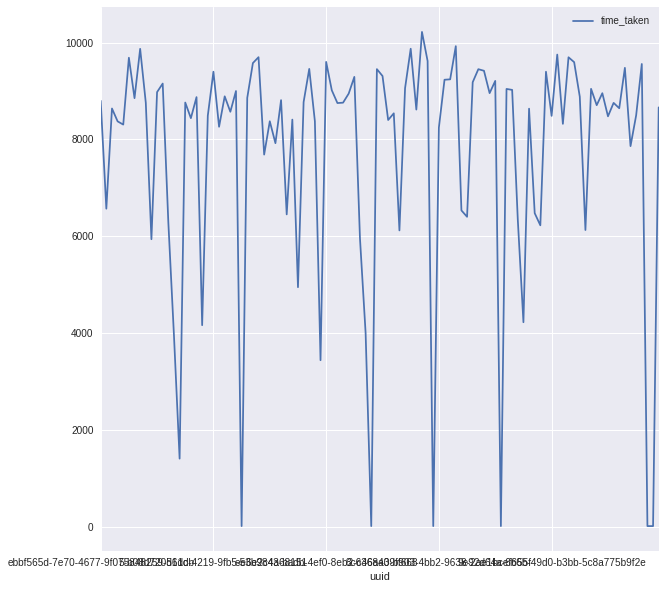

In [64]:
import matplotlib.pyplot as plt
# import bokeh
import seaborn as sns

% matplotlib inline
# import mpld3
# mpld3.enable_notebook()


data[:100].plot(x='uuid',y='time_taken',figsize=(10,10))